In [42]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pandas import read_csv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
import math
import gc


In [2]:
model_name = "model_large"
img_width = 200
img_height = 66
img_channels = 3
model_file = "models/{}-{}x{}x{}".format(model_name[6:], img_width, img_height, img_channels)


In [29]:
import requests 
import os
import zipfile

dataset_dir = "dataset"
dataset_zipfile = 'Dataset.zip'
RunningInCOLAB = 'google.colab' in str(get_ipython())
force_unzip = True

if RunningInCOLAB: 
    print("in colab")
    from google.colab import files
    uploaded = files.upload()
    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))
        dataset_zipfile = fn  # expecting a zip file to be uploaded. 
else:
    print ("not in colab")
    # RPI_IP=None # replace this with the IP address of your raspberry pi 
    # if RPI_IP is not None:
    #     URL="http://"+RPI_IP+":8000/"+dataset_zipfile
    #     filename=URL.split('/')[-1]
    #     r = requests.get(URL)
    #     open(filename, 'wb').write(r.content)

if not os.path.isfile(dataset_zipfile):
    default_dataset_URL = "https://raw.githubusercontent.com/heechul/DeepPicar-v3/devel/Dataset-kucsl-Apr2022.zip"    
    print ("No existing dataset. download from ", default_dataset_URL)
    r = requests.get(default_dataset_URL)
    open(dataset_zipfile, 'wb').write(r.content)

if not os.path.isdir(dataset_dir) or force_unzip==True:
    print ('unzip %s into %s folder' % (dataset_zipfile, dataset_dir))
    zip_ref = zipfile.ZipFile(dataset_zipfile)
    zip_ref.extractall(dataset_dir)

in colab


unzip Dataset.zip into dataset folder


In [33]:
import shutil

# This function force deletes a folder in colab,
# since colab does not allow deleting non empty folders
shutil.rmtree('Dataset')

In [4]:
from keras import layers

# DNN model is defined here, sequential models
# can only link one layer to another at a time
model = tf.keras.Sequential()
# convolutional layers produce u filters using (v, w) kernel sizes (windows)
# with (x, y) strides (movement)
model.add(layers.Conv2D(24, (5,5), strides=(2,2), activation='relu', input_shape=(img_height,img_width,img_channels)))
model.add(layers.Conv2D(36, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(48, (5,5), strides=(2,2), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
# flatten makes 2d convolution into one big array of simple neurons
model.add(layers.Flatten())
# dense layers have all outputs connected to all inputs
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1))

In [34]:
# Train/test data lists
imgs = []
vals = []

import glob
for vid_file_path in glob.iglob(f'{dataset_dir}/*.avi'):
    csv_file_path = vid_file_path.replace('video', 'key').replace('avi', 'csv')
    print(vid_file_path, csv_file_path)

    vid = cv2.VideoCapture(vid_file_path)
    ret,img = vid.read()
    while(ret):
        # Convert to grayscale and readd channel dimension
        if img_channels == 1:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (img_width, img_height))
            img = np.reshape(img, (img_height, img_width, img_channels))
        # For RGB, just need to resize image
        else:
            img = cv2.resize(img, (img_width, img_height))
        img = img / 255.
        imgs.append(img)
        ret,img = vid.read()
    df = read_csv(csv_file_path)
    temp = np.asarray(df["wheel"].values)
    vals.extend(temp)
    # print(len(imgs), len(vals))    

# Convert lists to numpy arrays and ensure they are of equal length    
imgs = np.asarray(imgs)  # input images
vals = np.asarray(vals)  # steering angles
assert len(imgs) == len(vals)
print("Loaded {} smaples".format(len(imgs)))

dataset/out-video (3).avi dataset/out-key (3).csv
dataset/out-video.avi dataset/out-key.csv
dataset/out-video (1).avi dataset/out-key (1).csv
Loaded 6033 smaples


In [35]:
# Split the dataset for train and test 
print("Train/Test")
# label encoder changes the labels (output) into a integers 0, 1, 2...
# this normalizes the output for the network so each outputs are treated the same
le = preprocessing.LabelEncoder()
vals = le.fit_transform(vals)

# train_test_split splits the data into a training set and a test set
# we do this because we want to check our network against test data it has
# not seen before
x_train, x_test, y_train, y_test = train_test_split(imgs, vals, test_size=0.25)
del vals
gc.collect()

Train/Test


22756

In [37]:
print ("Model compile")
# the optimizer defines how we train the model
# Adam is an optimizer than handles how we randomly move during
# the optimization process
# the number we pass in here (0.0001) is the initial learning rate
# it determines how much of the weight we change, so how quickly we move
# around the space
optimizer = tf.keras.optimizers.Adam(1e-4)

# this is for when we want to continue training an existing model
# existing models are saved in a .h5 file
if os.path.isfile(model_file+".h5"):
    model = tf.keras.models.load_model(model_file+".h5")
    optimizer = optimizer=tf.keras.optimizers.Adam(5e-5)
# the loss function is how we calculate how closely our model's outputs
# are to the ground truth
# common loss functions are Mean Absolute Error (MAE), Mean Squared Error (MSE),
# and Huber Loss
model.compile(optimizer=optimizer,
                loss='huber', metrics=['mae'])
model.summary()

Model compile
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)  

Model fit
Epoch 1/20
71/71 [==============================] - 22s 306ms/step - loss: 0.1033 - mae: 0.3312 - val_loss: 0.0990 - val_mae: 0.3551
Epoch 2/20
71/71 [==============================] - 22s 305ms/step - loss: 0.0963 - mae: 0.3307 - val_loss: 0.0907 - val_mae: 0.3344
Epoch 3/20
71/71 [==============================] - 22s 306ms/step - loss: 0.0903 - mae: 0.3216 - val_loss: 0.0882 - val_mae: 0.3217
Epoch 4/20
71/71 [==============================] - 22s 305ms/step - loss: 0.0844 - mae: 0.3123 - val_loss: 0.0815 - val_mae: 0.3130
Epoch 5/20
71/71 [==============================] - 22s 306ms/step - loss: 0.0814 - mae: 0.3072 - val_loss: 0.0817 - val_mae: 0.3134
Epoch 6/20
71/71 [==============================] - 22s 308ms/step - loss: 0.0788 - mae: 0.3018 - val_loss: 0.0791 - val_mae: 0.3048
Epoch 7/20
71/71 [==============================] - 22s 303ms/step - loss: 0.0761 - mae: 0.2988 - val_loss: 0.0796 - val_mae: 0.2997
Epoch 8/20
71/71 [==============================] - 22s 305

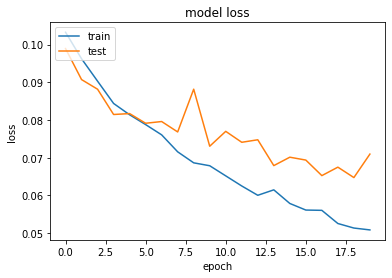

In [43]:
print ("Model fit")

# In case our training data is not balanced
# say we have data for 2 left turn, 4 right turn, and 20 center,
# In that case, we don't want the center data to drown out the left and right data
# Balanced class weights give more priority to sparse data to ensure they have
# just as much impact on our model
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
class_weights = dict(zip(np.unique(y_train), class_weights))

# This trains the model
history = model.fit(x_train, y_train, batch_size=64,
                    epochs=20, validation_data=(x_test, y_test), class_weight=class_weights)
# Plot training and validation losses 
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
# This function gives us a more readable output
def get_action(label):
  if label < 0.5:
    return "left"
  elif label >= 0.5 and label <= 1.5:
    return "center"
  elif label > 1.5:
    return "right"

In [45]:
pred = model.predict(x_test)
pred = np.array(list(map(get_action, pred)))
ground = np.array(list(map(get_action, y_test)))
print('Accuracy is %.3f' % np.mean(pred == ground))
print(classification_report(pred, ground))

Accuracy is 0.825
              precision    recall  f1-score   support

      center       0.74      0.89      0.81       626
        left       0.91      0.80      0.85       636
       right       0.90      0.72      0.80       247

    accuracy                           0.83      1509
   macro avg       0.85      0.80      0.82      1509
weighted avg       0.84      0.83      0.83      1509



In [46]:
# Save both the Keras and TFLite models      
print("Model Save")                  
model.save(model_file+".h5")

print("TFLite Model")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_types = [tf.float16]

quantized_tflite_model = converter.convert()

with open(model_file+".tflite", 'wb') as f:
    f.write(quantized_tflite_model)

print (model_file+".tflite is saved. copy this file to the robot")

if RunningInCOLAB: 
    from google.colab import files
    files.download(model_file+".tflite")

Model Save
TFLite Model
INFO:tensorflow:Assets written to: /tmp/tmplryp7fq_/assets


INFO:tensorflow:Assets written to: /tmp/tmplryp7fq_/assets


models/large-200x66x3.tflite is saved. copy this file to the robot


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>